# Linear Attention KV Cache计算

LinearAttention在 KV Cache的存储上具备多大优势？

本例将通过对 SSM（状态空间模型）、MLA（多头潜在注意力）与 GQA（分组查询注意力）三者所需的 Cache 大小进行理论计算与对比，来定量探讨这一问题。

相关文章：

- [LinearAttention在KV cache的存储上有多大优势？](https://www.zhihu.com/question/1974064489159730057/answer/1974067690864928547)

Author: kaiyuan

Email: kyxie@zju.edu.cn

SSM的cache计算公式：

- S:= 2 * num_v_heads / TP * head_k_dim * head_v_dim
- Conv:= 2 * (head_k_dim * num_k_heads * 2 + head_v_dim * num_v_heads)/TP * (conv_kernel_size - 1)

在MLA/GQA中 kv cache的存储大小与序列长度相关，计算公式：

- MLA:= 2 * seq_len * (kv_lora_rank + qk_rope_head_dim)

- GQA:= 2 * 2 * seq_len * num_key_value_heads * head_dim / TP

## 1 KDA KV cache的计算




In [ ]:
# 默认参数：
head_k_dim = 128
head_v_dim = 128
num_k_heads = 32
num_v_heads = 32
TP = 1
conv_kernel_size = 4
kv_lora_rank = 512
qk_rope_head_dim = 64

ssm = 2 * num_v_heads / TP * head_k_dim * head_v_dim
conv = 2 * (head_k_dim * num_k_heads * 2 + head_v_dim * num_v_heads)/TP  * (conv_kernel_size - 1)

kda_linear = ssm + conv

def mla_cache(seq_len):
  return 2 * seq_len * (kv_lora_rank + qk_rope_head_dim)

975


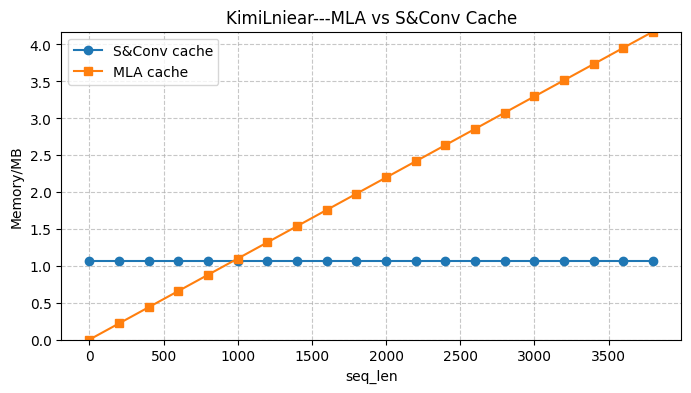

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_data(x, base_data, linear_data, mla_data, plot_extra=10, title = "MLA Prefill", xlable='seq_len'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  max_y = 0
  # 绘制多条折线
  if base_data is not None:
    plt.plot(x, base_data, label='None', marker='o')
    max_y = max(max_y, max(base_data))
  if linear_data is not None:
    plt.plot(x, linear_data, label='S&Conv cache', marker='o')
    max_y = max(max_y, max(linear_data))
  if mla_data is not None:
    plt.plot(x, mla_data, label='MLA cache', marker='s')
    max_y = max(max_y, max(mla_data))

  plt.ylim(0, max_y + plot_extra)


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Memory/MB')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

x = []
linear_data = []
mla_data = []
flag = True

for i in range(0, 4000, 1):
  if i%200==0:
    x.append(i)
    linear_data.append(kda_linear/(1024*1024))
    mla_data.append(mla_cache(i)/(1024*1024))
  if flag and kda_linear <= mla_cache(i):
    print(i)
    flag = False


plot_data(x, None, linear_data, mla_data, plot_extra=0, title = "KimiLniear---MLA vs S&Conv Cache")

## 2 Qwen Next模型

In [ ]:
# 参数：
head_k_dim = 128
head_v_dim = 128
num_k_heads = 16
num_v_heads = 32
TP = 1
conv_kernel_size = 4
num_key_value_heads = 2
head_dim = 256

ssm = 2 * num_v_heads / TP * head_k_dim * head_v_dim
conv = 2 * (head_k_dim * num_k_heads * 2 + head_v_dim * num_v_heads)/TP  * (conv_kernel_size - 1)

gdn_linear = ssm + conv

def gqa_cache(seq_len):
  # 2 * type_factor * seq_len * num_key_value_heads * head_dim  其中type_factor=2
  return 2 *  2 * seq_len * num_key_value_heads * head_dim / TP

536


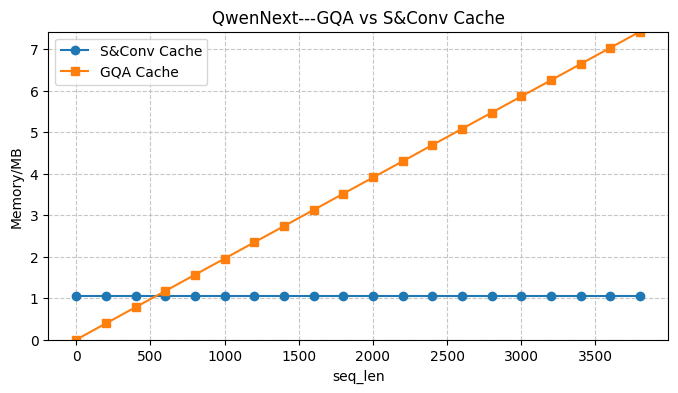

In [ ]:
def plot_data(x, base_data, linear_data, gqa_data, plot_extra=10, title = "MLA Prefill", xlable='seq_len'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  max_y = 0
  # 绘制多条折线
  if base_data is not None:
    plt.plot(x, base_data, label='None', marker='o')
    max_y = max(max_y, max(base_data))
  if linear_data is not None:
    plt.plot(x, linear_data, label='S&Conv Cache', marker='o')
    max_y = max(max_y, max(linear_data))
  if gqa_data is not None:
    plt.plot(x, gqa_data, label='GQA Cache', marker='s')
    max_y = max(max_y, max(gqa_data))

  plt.ylim(0, max_y + plot_extra)


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Memory/MB')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

x = []
linear_data = []
gqa_data = []
flag = True

for i in range(0, 4000, 1):
  if i%200==0:
    x.append(i)
    linear_data.append(gdn_linear/(1024*1024))
    gqa_data.append(gqa_cache(i)/(1024*1024))
  if flag and gdn_linear <= gqa_cache(i):
    print(i)
    flag = False


plot_data(x, None, linear_data, gqa_data, plot_extra=0, title = "QwenNext---GQA vs S&Conv Cache")

## 3 prefix cache特性

由于线性注意力层保留的是最后的状态，所以一般而言前缀缓存（prefix cache）只能匹配最长序列。如果要匹配中间的结果，得让线性注意力层保存对应的S&Conv的中间状态数据。考虑的实现方案：

- 离散保存：按照block为单位进行状态保存，例如128个tokens保存一次S&Conv。这种方式下存储cache呈现分段增长。
- 以算换存：存储GDD/KDA的输入值hidden states，或者映射后的输入值（k/v/alpha/beta），通过重算的方式恢复S；


### 离散保存


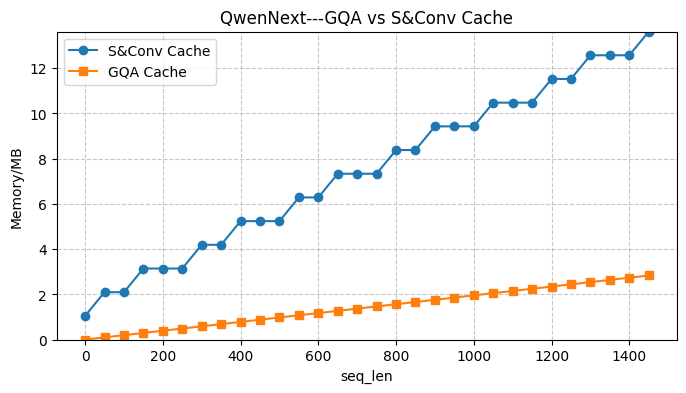

In [ ]:
# Qwen3-Next-80B-A3B-Instruct
head_k_dim = 128
head_v_dim = 128
num_k_heads = 16
num_v_heads = 32
TP = 1
conv_kernel_size = 4
num_key_value_heads = 2
head_dim = 256

ssm = 2 * num_v_heads / TP * head_k_dim * head_v_dim
conv = 2 * (head_k_dim * num_k_heads * 2 + head_v_dim * num_v_heads)/TP  * (conv_kernel_size - 1)

gdn_linear = ssm + conv

def gqa_cache(seq_len):
  return 2 * 2 * seq_len * num_key_value_heads * head_dim / TP


def plot_data(x, base_data, linear_data, gqa_data, plot_extra=10, title = "MLA Prefill", xlable='seq_len'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  max_y = 0
  # 绘制多条折线
  if base_data is not None:
    plt.plot(x, base_data, label='None', marker='o')
    max_y = max(max_y, max(base_data))
  if linear_data is not None:
    plt.plot(x, linear_data, label='S&Conv Cache', marker='o')
    max_y = max(max_y, max(linear_data))
  if gqa_data is not None:
    plt.plot(x, gqa_data, label='GQA Cache', marker='s')
    max_y = max(max_y, max(gqa_data))

  plt.ylim(0, max_y + plot_extra)


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Memory/MB')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

# 如果不作分段存储。必备cpu offload功能。
x = []
linear_data = []
gqa_data = []
gdn_linear_cache = gdn_linear

for i in range(0, 1500, 1):
  if i%50==0:
    x.append(i)
    linear_data.append(gdn_linear_cache/(1024*1024))
    gqa_data.append(gqa_cache(i)/(1024*1024))
  if i % 128 ==0:
    gdn_linear_cache += gdn_linear


plot_data(x, None, linear_data, gqa_data, plot_extra=0, title = "QwenNext---GQA vs S&Conv Cache")

### 几种方式的对比


用Qwen3-Next-80B-A3B-Instruct的参数，对比三种情况：

- 保存hidden states
- 保存k/v/alpha/beta
- 参考系：离散存储S&Conv（128tokens保存一次）

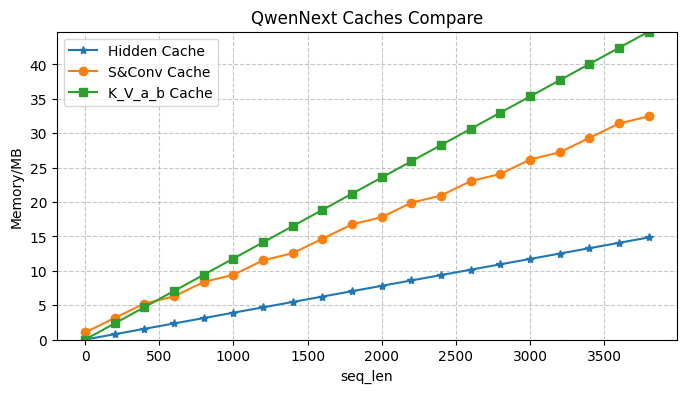

In [ ]:
# K/V/a/b的保存形态：k_v_a_b
def calcu_kvab_cache(seq_len):
  return 2 * seq_len * (head_k_dim * num_k_heads + head_v_dim * num_v_heads + num_v_heads)

hidden_size = 2048
def caclcu_hidden_cache(seq_len):
  return 2 * seq_len * hidden_size

def gqa_cache(seq_len):
  return 2 * 2 * seq_len * num_key_value_heads * head_dim / TP


def plot_data(x, base_data, linear_data, gqa_data, plot_extra=10, title = "MLA Prefill", xlable='seq_len'):

  # 创建图形
  plt.figure(figsize=(8, 4))
  max_y = 0
  # 绘制多条折线
  if base_data is not None:
    plt.plot(x, base_data, label='Hidden Cache', marker='*')
    max_y = max(max_y, max(base_data))
  if linear_data is not None:
    plt.plot(x, linear_data, label='S&Conv Cache', marker='o')
    max_y = max(max_y, max(linear_data))
  if gqa_data is not None:
    plt.plot(x, gqa_data, label='K_V_a_b Cache', marker='s')
    max_y = max(max_y, max(gqa_data))

  plt.ylim(0, max_y + plot_extra)


  # 添加标题和标签
  plt.title(title)
  plt.xlabel(xlable)
  plt.ylabel('Memory/MB')

  # 添加图例
  plt.legend()

  # 显示网格
  plt.grid(True, linestyle='--', alpha=0.7)

  # 显示图形
  plt.show()

# 如果不作分段存储。必备cpu offload功能。
x = []
linear_data = []
kvab_data = []
gdn_linear_cache = gdn_linear
hidden_data = []

for i in range(0, 4000, 1):
  if i%200==0:
    x.append(i)
    linear_data.append(gdn_linear_cache/(1024*1024))
    kvab_data.append(calcu_kvab_cache(i)/(1024*1024))
    hidden_data.append(caclcu_hidden_cache(i)/(1024*1024))
  if i % 128 ==0:
    gdn_linear_cache += gdn_linear


plot_data(x, hidden_data, linear_data, kvab_data, plot_extra=0, title = "QwenNext Caches Compare")
